In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from config import RESULTS, FIGURES
from code_.tools.plotting import *
from code_.model_activations.configs import analysis_cfg

In [2]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = analysis_cfg[DATASET]['regions']
model_name = 'expansion'
features_list = analysis_cfg[DATASET]['analysis']['pca']['features']

In [3]:
# expansion model data
df_expansion = pd.read_csv(os.path.join(RESULTS, 'bootstrap-results' + '-' + 'expansion' + '-' + DATASET + '-' + region + '.csv'))
df_expansion['model'] = model_name
df_expansion['score'] = df_expansion['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

# expansion pca data
df_pcs = pd.read_csv(os.path.join(RESULTS, 'bootstrap-results' + '-' + 'pca' + '-' + DATASET + '-' + region + '.csv'))

df_pcs['score'] = df_pcs['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
df_pcs['model'] = 'expansion' + '_' + df_pcs['features'].astype(str)
# df_pcs['pcs'] = df_pcs['pcs'].apply(lambda x: int(x))
df_pcs['full_model_score'] = df_pcs['features'].apply(lambda x: df_expansion[(df_expansion.features == x)].reset_index(drop=True).score[0])

In [4]:
# plot data
rcParams['figure.figsize'] = (7,7)  

names = {}
p = 2
for i in [3,30,300,3000,30000]: 
    names[f'expansion_{i}'] = f'Features = {write_powers(p)}'
    p+=1
df_pcs['model_iden'] = df_pcs['model'].map(names)

palette_blues = {}
blues = plt.cm.Blues([0.2, 0.4, 0.6, 0.8, 1.0])
hex_blues= [mcolors.rgb2hex(color) for color in blues]

for c, hex_color in enumerate(hex_blues):
    palette_blues[f'Features = {write_powers(c+2)}'] = hex_color
df_pcs['color'] = df_pcs['model_iden'].map(palette_blues)

# filterfeatures =3 and pcs = 1000, its actually fetaures = 108, since the mdoel doesnt have 1000 features. 
df_pcs = df_pcs.drop(df_pcs[(df_pcs["features"] == 3) & (df_pcs["pcs"] == 1000)].index).reset_index(drop=True)

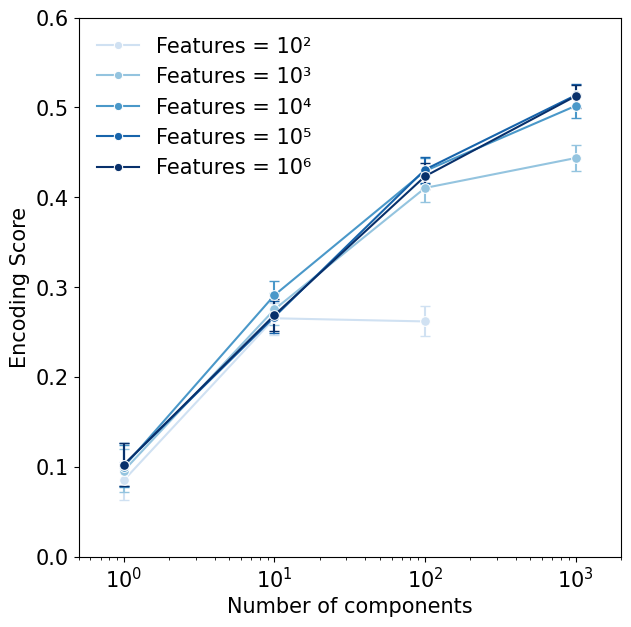

In [5]:

for i in range(len(df_pcs)):
    plt.errorbar(df_pcs['pcs'][i], df_pcs['score'][i], 
                 yerr=[[df_pcs['score'][i] - df_pcs['lower'][i]], [df_pcs['upper'][i] - df_pcs['score'][i]]], 
                 fmt='none', capsize=5, color=df_pcs['color'][i])   
ax1 = sns.lineplot(data = df_pcs, x='pcs', y='score', hue='model_iden', dashes=False, marker='o', palette = palette_blues)

plt.xlabel("Number of components",size=15)
plt.ylabel('Encoding Score',size=15)
plt.xlim(df_pcs['pcs'].min()/2,df_pcs['pcs'].max()*2)
plt.ylim(0,0.6) if region == 'IT' else plt.ylim(0,0.30)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.legend(title='',frameon=False,fontsize=15) if region == 'IT' else ax1.legend_.remove()
ax1.set_xscale("log")    
plt.setp(plt.gca().get_lines(), markersize=7)  # Change 9 to your desired marker size
plt.savefig(os.path.join(FIGURES,f'figure_3_{DATASET}_{region}.png'), dpi=200) 
plt.show()

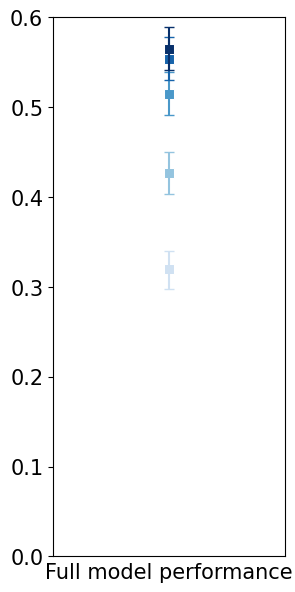

In [6]:
# plot full model results
rcParams['figure.figsize'] = (3,7)  

df_pcs['model_family'] = 'Convolutional'
ax1 = sns.lineplot(data = df_pcs, x='model_family', y='full_model_score', hue='model_iden', 
                   dashes=False, style='model_family', 
                   marker='s', palette = palette_blues)

for i in range(len(df_pcs)):
    if df_pcs.iloc[i]['pcs'] == 1:
        plt.errorbar(df_pcs['model_family'][i], df_pcs['full_model_score'][i], 
                    yerr=[[df_pcs['score'][i] - df_pcs['lower'][i]], [df_pcs['upper'][i] - df_pcs['score'][i]]], 
                    fmt='none', capsize=5, color=df_pcs['color'][i])   

plt.xlabel("Full model performance",size=15)
plt.ylabel('')
plt.xlim(-10,10)
plt.ylim(0,0.6) if region == 'IT' else plt.ylim(0,0.30)
ax1.legend_.remove()    
plt.yticks(size=15)
ax1.set_xticks([])
plt.setp(plt.gca().get_lines(), markersize=7)  # Change 9 to your desired marker size
plt.savefig(os.path.join(FIGURES, f'figure_3_pt_2_{DATASET}_{region}.png'), dpi=200) 
plt.show()